# Project 2

## Summary of Project

# Hypothesis or A/B Testing

## Three Tests
1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
2. Do US employees sell significantly more than UK employees
3. Does an employees age have a statistically signifiant effect on order totals
4. Do countries shipped have a statistically significant effect on discounts

In [36]:
#import libraries and functions
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
%matplotlib inline

In [3]:
#get sql database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [4]:
#function to pull sql queries and return a pandas table
def query_to_df(query):
    cur.execute(query)
    df = pd.DataFrame(cur.fetchall())
    df.columns = [x[0] for x in cur.description]
    return df

In [65]:
#Show names of all the tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


# Functions

In [13]:
def find_s(a, b):
#a and b are arrays from the control and experimental group
#used to find the s in the denominator of cohen's d equatin to find effect size
    num = (len(a)-1)*(a.std())**2 + (len(b)-1)*(b.std())**2
    denom = len(a) + len(b)
    return np.sqrt(num/denom)

In [28]:
#Calculate what sample size is needed for Control and Experimental
def get_sample_size(alpha, power, a, b):
    power_analysis = TTestIndPower()
    alpha = 0.05
    power = 0.80
    mean_difference = abs(a.mean()-b.mean())
    s = find_s(a, b)
    effect_size = mean_difference / s
    sample_size = power_analysis.solve_power(alpha=.05, effect_size=effect_size, power=.80, alternative='larger')
    print("""Using alpha = {}, effect size = {}, and power = {}: 
             The sample size should be {}""".format(alpha, effect_size, power, sample_size))
    return int(np.round(sample_size) + 1)

In [269]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = d1.var(), d2.var()
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = d1.mean(), d2.mean()
    # calculate the effect size
    return (u1 - u2) / s

# 1

## Explore Data

In [5]:
#query 1
#Need Discount & Quantity from OrderDetail table
query1 = """SELECT Discount, Quantity
            FROM OrderDetail;"""
df1 = query_to_df(query1)

In [6]:
df1.head()

,Discount,Quantity
0,0.0,12
1,0.0,10
2,0.0,5
3,0.0,9
4,0.0,40


In [7]:
df1.describe()

,Discount,Quantity
count,2155.000000,2155.000000
mean,0.056167,23.812993
std,0.083450,19.022047
min,0.000000,1.000000
25%,0.000000,10.000000
50%,0.000000,20.000000
75%,0.100000,30.000000
max,0.250000,130.000000


## Null Hypothesis:
There is no significant effect from discount on quantity of a product in an order

## Alternative Hypothesis:
There is a signifiant effect from discount on quantity of a product in an order

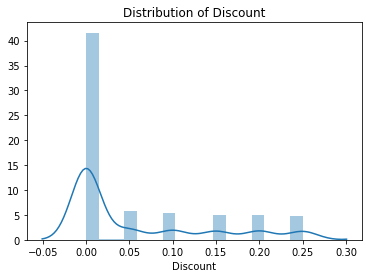

In [8]:
#seaborn distplot
sns.distplot(df1.Discount);
plt.title('Distribution of Discount');

### Observations of Discount
- Discount is an ordinal variable
- Most orders have a 0% discount
- Has a very long right tail

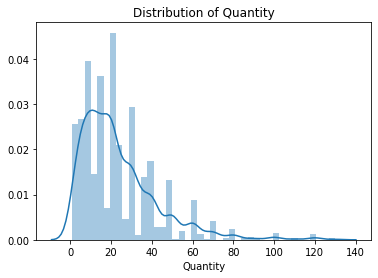

In [9]:
sns.distplot(df1.Quantity);
plt.title('Distribution of Quantity');

### Observations of Quantity (The dependant variable)
- Positively skewed
- Minimum value is 1, max value is 130
- The mean is around 20

## Run Anova Test
why?
For an ANOVA Test, any categorical variable has to be broken down into dummy varaibles. For this ANOVA test it will compare Quantity to whether or not there was a discount. So I will create a new column that has a '1' for discount present, and '2' for no discount

In [252]:
df1['Discount_Present'] = 1
df1.loc[df1.Discount == 0, 'Discount_Present'] = 0

In [254]:
df1.Discount_Present.value_counts()

0    1317
1     838
Name: Discount_Present, dtype: int64

In [255]:
#run anova test
formula = 'Quantity ~ C(Discount_Present)'
lm = ols(formula, df1).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                            sum_sq      df          F        PR(>F)
C(Discount_Present)   14903.513199     1.0  41.971781  1.144092e-10
Residual             764496.122996  2153.0        NaN           NaN


### The Null Hypothesis is Rejected


## Find the Effect Size of Discount

In [256]:
#statistical analysis 1
#make control group, discount = 0
control = df1[df1['Discount']==0]
control.describe()

,Discount,Quantity,Discount_Present
count,1317.0,1317.000000,1317.0
mean,0.0,21.715262,0.0
std,0.0,17.507493,0.0
min,0.0,1.000000,0.0
25%,0.0,10.000000,0.0
50%,0.0,18.000000,0.0
75%,0.0,30.000000,0.0
max,0.0,130.000000,0.0


In [257]:
#make experimental group, discount != 0
experimental = df1[df1['Discount']!=0]
experimental.describe()

,Discount,Quantity,Discount_Present
count,838.000000,838.000000,838.0
mean,0.144439,27.109785,1.0
std,0.071808,20.771439,0.0
min,0.010000,1.000000,1.0
25%,0.100000,12.000000,1.0
50%,0.150000,20.000000,1.0
75%,0.200000,36.000000,1.0
max,0.250000,130.000000,1.0


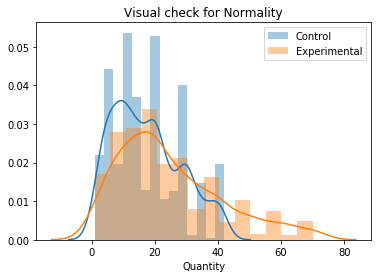

In [261]:
#Plot Control and Experimental to check for Normality
sns.distplot(control.Quantity, label='Control');
sns.distplot(experimental.Quantity, label='Experimental');
plt.title('Visual check for Normality');
plt.legend();

### Observations
1. Positively skewed
2. A lot of overlap
3. There a a couple of outliers that I will remove. I will set the Quantity limit to 80

In [260]:
control = control.loc[control.Quantity <= control.Quantity.quantile(.95)]
experimental = experimental.loc[experimental.Quantity <= experimental.Quantity.quantile(.95)]

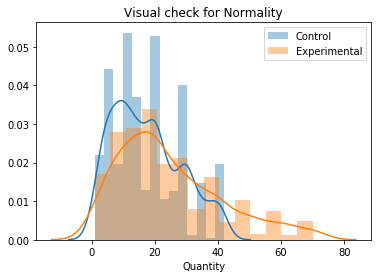

In [262]:
sns.distplot(control.Quantity, label='Control');
sns.distplot(experimental.Quantity, label='Experimental');
plt.title('Visual check for Normality');
plt.legend();

In [264]:
#Find difference of means between no-discount and discount
mean_diff = experimental.Quantity.mean()-control.Quantity.mean()
print(mean_diff)

7.262312638281518


In [272]:
#Find Cohen's D
d = cohend(experimental.Quantity, control.Quantity)
print(d)

0.5435088994920753


In [283]:
a = statsmodels.stats.power.tt_ind_solve_power(effect_size=d, alpha=.05, nobs1=len(experimental))
print(a)

1.0


### Elaborate on the Cohen's D value, effect size and why you ran the tt solve power test

## Step 2: Create a Sample Distribution using the Sample Means

In [29]:
sample_size = int(get_sample_size(0.05, 0.80, control.Quantity, experimental.Quantity))
sample_size

Using alpha = 0.05, effect size = 0.28641058366376687, and power = 0.8: 
             The sample size should be 151.41800022641124


152

In [30]:
#Create samples 10,000 times from control and experimental groups
def get_sample_means(a, sample_size, num_of_samples):
    #a is an array of values to sample from
    #sample_size is defined above using get_sample_size
    #num_of_samples is the number of samples to take
    sample_means = []
    for i in range(num_of_samples):
        sample = a.sample(sample_size)
        sample_means.append(sample.mean())
    return sample_means

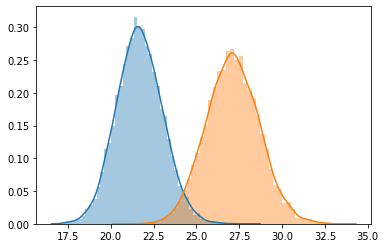

In [31]:
#With the sample mean values, graph control vs. experimental again.
sns.distplot(control_sample_means);
sns.distplot(experimental_sample_means);

In [32]:
welchs_t_test_p_value = stats.ttest_ind(control_sample_means, experimental_sample_means, equal_var=False)[1]/2
print("Running Welch's T-Test gives a p-value of:",welchs_t_test_p_value)

Running Welch's T-Test gives a p-value of: 0.0


                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


In [41]:
#Break df into each discount amount
#Use Tukey's HSD
mc = statsmodels.sandbox.stats.multicomp.MultiComparison(df1['Quantity'], df1['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   0.0   0.01 -19.7153    0.9 -80.3306 40.9001  False
   0.0   0.02 -19.7153    0.9  -62.593 23.1625  False
   0.0   0.03 -20.0486  0.725 -55.0714 14.9742  False
   0.0   0.04 -20.7153    0.9 -81.3306 39.9001  False
   0.0   0.05   6.2955 0.0011   1.5381  11.053   True
   0.0   0.06 -19.7153    0.9 -80.3306 40.9001  False
   0.0    0.1   3.5217 0.4269  -1.3783  8.4217  False
   0.0   0.15   6.6669 0.0014    1.551 11.7828   True
   0.0    0.2   5.3096 0.0303   0.2508 10.3684   True
   0.0   0.25    6.525 0.0023   1.3647 11.6852   True
  0.01   0.02      0.0    0.9 -74.2101 74.2101  False
  0.01   0.03  -0.3333    0.9 -70.2993 69.6326  False
  0.01   0.04     -1.0    0.9 -86.6905 84.6905  False
  0.01   0.05  26.0108    0.9  -34.745 86.7667  False
  0.01   0.06      0.0    0.9 -85.6905 85.6905  False
  0.01    0.1   23.237    0.

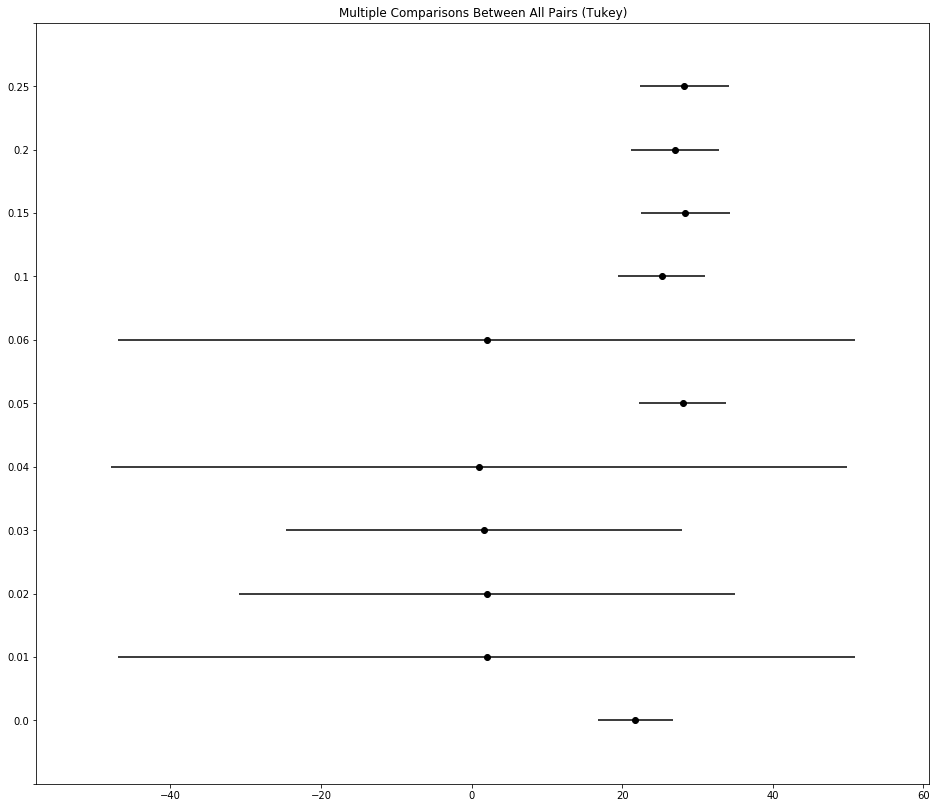

In [40]:
mc = statsmodels.sandbox.stats.multicomp.MultiComparison(df1['Quantity'], df1['Discount'])
mc_results = mc.tukeyhsd()
mc_results = mc_results.plot_simultaneous(figsize=(16,14))
plt.show()

In [92]:
def run_welchs_ttest(control, experimental):
    welchs_t_test_p_value = stats.ttest_ind(control, experimental, equal_var=False)[1]/2
    print("Running Welch's T-Test gives a p-value of:",welchs_t_test_p_value)

In [ ]:
#query 2

In [6]:
#statistical analysis 2

In [ ]:
#graphs 2

In [7]:
#query 3

In [ ]:
#statistical analysis 3

In [5]:
#graphs 3

# 2

In [217]:
query2 = """SELECT Country, EmployeeId, OrderId, SUM(UnitPrice*Quantity*(1-Discount)) as TotalSales
            FROM Employee
            JOIN [Order]
                ON [Order].EmployeeId = Employee.ID
            JOIN OrderDetail
                ON [Order].Id = OrderDetail.OrderId
            GROUP BY OrderID
            ;"""

In [218]:
df2 = query_to_df(query2)
df2.head()

,Country,EmployeeId,OrderId,TotalSales
0,UK,5,10248,440.00
1,UK,6,10249,1863.40
2,USA,4,10250,1552.60
3,USA,3,10251,654.06
4,USA,4,10252,3597.90


# 3 

In [219]:
query3 = """SELECT Birthdate, EmployeeId, OrderId, SUM(UnitPrice*Quantity*(1-Discount)) as TotalSales
            FROM Employee
            JOIN [Order]
                ON [Order].EmployeeId = Employee.ID
            JOIN OrderDetail
                ON [Order].Id = OrderDetail.OrderId
            GROUP BY OrderID
            ;"""

In [220]:
df3 = query_to_df(query3)
df3.head()

,BirthDate,EmployeeId,OrderId,TotalSales
0,1987-03-04,5,10248,440.00
1,1995-07-02,6,10249,1863.40
2,1969-09-19,4,10250,1552.60
3,1995-08-30,3,10251,654.06
4,1969-09-19,4,10252,3597.90


# 4

In [246]:
query4 = """SELECT ShipCountry, OrderId, Discount
           FROM [Order]
           JOIN OrderDetail
                ON [Order].Id = OrderDetail.OrderId
            ;"""

In [247]:
df4 = query_to_df(query4)
df4.head()

,ShipCountry,OrderId,Discount
0,France,10248,0.0
1,France,10248,0.0
2,France,10248,0.0
3,Germany,10249,0.0
4,Germany,10249,0.0


In [248]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
ShipCountry    2155 non-null object
OrderId        2155 non-null int64
Discount       2155 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 50.6+ KB


In [250]:
df4.ShipCountry.value_counts()

USA            352
Germany        328
Brazil         203
France         184
UK             135
Austria        125
Venezuela      118
Sweden          97
Canada          75
Mexico          72
Belgium         56
Ireland         55
Finland         54
Spain           54
Italy           53
Switzerland     52
Denmark         46
Argentina       34
Portugal        30
Norway          16
Poland          16
Name: ShipCountry, dtype: int64

# Conclusion